## Seleção de Patch de Maneira Dinâmica

In [1]:
from PIL import Image
import numpy as np
import random
random.seed(10)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Realizando abertura da imagem com a bib PILLOW
path_image = "../data/base_recortada/ASC-H/10.png"
im = Image.open(path_image)
im.format, im.size, im.mode

('PNG', (180, 180), 'RGB')

In [3]:
# im = im.rotate(45)

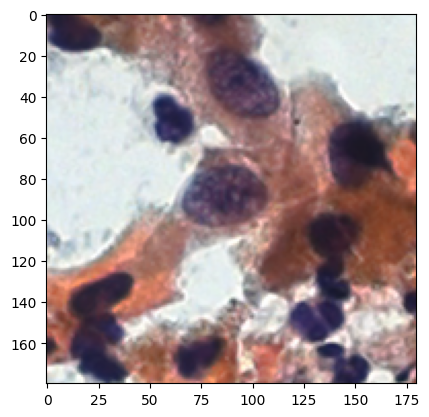

In [4]:
plt.imshow(im)
plt.show()

### Normal Pixels

In [5]:
def visualize_patch_centers(image, centers, patch_size):
    # cria o ax para plotar a img
    fig, ax = plt.subplots(1)
    
    # convert para np
    image_np = np.array(image)
    
    # normaliza a img para intervalo de 0 e 1
    if image_np.max() > 1:
        image_np = image_np / 255.0
    
    ax.imshow(image_np)
    
    patch_height, patch_width = patch_size
    
    for (h, w) in centers:
        rect = patches.Rectangle(
            (w - patch_width // 2, h - patch_height // 2), 
            patch_width, patch_height,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        plt.plot(w, h, marker='v', color='r')
    
    # Ajusta limite das imagens para proporcao correta
    ax.set_xlim([0, image_np.shape[1]])
    ax.set_ylim([image_np.shape[0], 0])
    
    plt.show()

196
(8, 8)


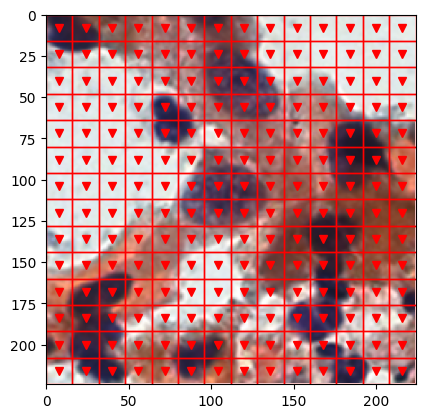

In [6]:
def generate_patch_centers(image_height, image_width, patch_size):
  
    # Stride é o espacamento entre os patches que é o próprio patch_size
    stride = patch_size  
    
    # Qtd de patches na height e no widget (SEM SOBREPOSICAO)
    num_patches_h = image_height // stride
    num_patches_w = image_width // stride
    
    centers_h = []
    centers_w = []
    
    # Todos os patches da coluna
    for i in range(num_patches_h):
      centers_h.append((i * stride + stride // 2))
    
    # Todos os patches da largura
    for j in range(num_patches_w):
      centers_w.append((j * stride + stride // 2))
    
    centers = []
    # Calculando a combinação das posicoes dos patches (X,Y)
    for h in centers_h:
      for w in centers_w:
        centers.append((h,w))
    
    # Retornar os pixels centrais
    return centers

# Variaveis
patch_size = 16
    
# Realizando resize na imagem com a bib PIL para 224x224
resized_image = im.resize((224,224))
centers = generate_patch_centers(224, 224, patch_size)
print(len(centers))
print(centers[0])

# Printa a visualizacao da imagem
visualize_patch_centers(resized_image, centers, (patch_size, patch_size))

-----

### Random Pixels

In [7]:
def generate_random_patch_centers(image_height, image_width, patch_size, num_patches):
    patch_height, patch_width = patch_size
    
    centers = []
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        centers.append((h, w))

    return centers

196
[(126.851739695502, 97.20892337242384), (128.24299063596985, 50.86843228501636), (177.17082028232255, 179.30648548695666), (143.92228705144456, 41.32774775591449), (116.29922680510431, 76.17674481739537), (59.99930875077128, 206.18591710234963), (215.28385444820668, 17.267727549690072), (186.91349575554852, 133.46364708138248), (87.37404507117651, 66.99258932459675), (148.39268820407085, 103.02087942012757), (150.6591889787157, 145.66403457088904), (35.659454100140266, 167.71026530035004), (212.3419557943277, 209.63273736422312), (135.57197867371548, 17.206211635841147), (8.843469984948753, 35.86628562621985), (203.72847245033347, 70.99499690204703), (84.1582851453687, 194.82481886415118), (73.38767143094174, 122.18829427458034), (98.69443918581743, 21.51878863438491), (129.58561494600147, 183.56612271367564), (40.53513502458053, 54.65418548669663), (93.87700320468687, 15.680372764194836), (111.29352771224202, 178.14043580136342), (144.8413152618947, 118.9646170157766), (185.866154

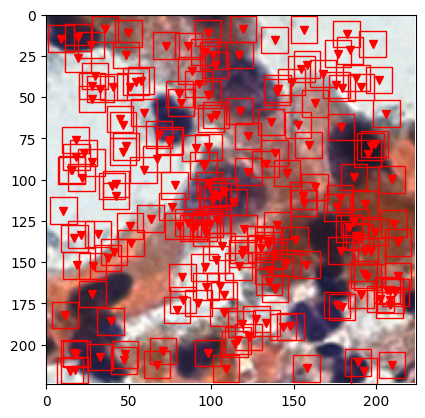

In [8]:
image_height = 224
image_width = 224
patch_size = (16, 16)
num_patches = 196
resized_image = im.resize((224,224))

patch_centers = generate_random_patch_centers(image_height, image_width, patch_size, num_patches)

# patch_centers = patch_centers[0:2]

print(len(patch_centers))
print(patch_centers)
visualize_patch_centers(resized_image, patch_centers, (16, 16))

---

### Random Pixels (Melhorado)

196
[(52.4950590021853, 71.6062615138464), (151.79023646654036, 95.13304090044869), (186.55305687784914, 85.81736620790792), (147.22558334226326, 32.03795042176547), (70.30397475172603, 185.0263129506135), (44.51295372895461, 138.1899711882697), (13.777962474395544, 134.73158335710664), (101.89588672310144, 195.07499719938582), (179.69483239993465, 168.8262894544134), (78.44817585785987, 147.16115487828864), (40.1918582392723, 109.87292083213863), (88.98912181423987, 105.68919874731857), (65.0111506895111, 52.03768735292567), (116.12900836404339, 143.95306628837454), (125.05564391578054, 206.23040355568094), (123.74144756021978, 39.043507168722726), (141.45595936595956, 73.84799129984665), (203.2160238177488, 35.01924833271885), (103.19262393630461, 148.13715950832287), (209.65560208109335, 116.55538721434766), (87.06626772033746, 169.46874904117544), (171.68772471629634, 198.04397703080147), (158.05875032746502, 34.54129271886132), (214.22043706506938, 201.5818650435443), (181.5328364

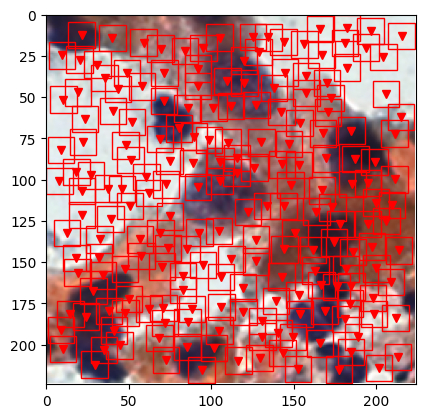

In [9]:
def pixels_adj(matriz, x, y, n_voltas):
    coords_voltas = []
    n_linhas, n_colunas = matriz.shape
    
    for volta in range(1, n_voltas + 1):
        for i in range(-volta, volta + 1):
            if 0 <= y + i < n_linhas:
                if 0 <= x - volta < n_colunas:
                    coords_voltas.append((y + i, x - volta))
                if 0 <= x + volta < n_colunas:
                    coords_voltas.append((y + i, x + volta))
        
        for j in range(-volta + 1, volta):
            if 0 <= x + j < n_colunas:
                if 0 <= y - volta < n_linhas:
                    coords_voltas.append((y - volta, x + j))
                if 0 <= y + volta < n_linhas:
                    coords_voltas.append((y + volta, x + j))
    coords_voltas.append((y,x))
    return coords_voltas

def verificar_adj(matriz, x, y, lista_centros):
    x, y = int(round(x)), int(round(y))  # Converta para inteiros
    if len(lista_centros) == 0:
        return False
    else:
        for each in lista_centros:
            each_x, each_y = int(round(each[1])), int(round(each[0]))
            ret = pixels_adj(matriz=matriz, x=each_x, y=each_y, n_voltas=8)
            if (y, x) in ret:  # Verifique na ordem correta
                return True
    return False

def random_patchs_melhorados(image_height, image_width, patch_size, num_patches, img_PIL):
    patch_height, patch_width = patch_size
    
    img_gray = img_PIL.convert('L')
    img_mtx = np.array(img_gray)
    
    centers = []
    
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        
        
        check = verificar_adj(img_mtx, w, h, centers)
        
        while check:
            h = random.uniform(patch_height / 2, image_height - patch_height / 2)
            w = random.uniform(patch_width / 2, image_width - patch_width / 2)
            check = verificar_adj(img_mtx, w, h, centers)
        
        centers.append((h, w))
    
    return centers

# Uso do código
image_height = 224
image_width = 224
patch_size = (16, 16)
num_patches = 196
imagem_rgb = im.convert('RGB')
resized_image = imagem_rgb.resize((224, 224))

patch_centers = random_patchs_melhorados(image_height, image_width, patch_size, num_patches, resized_image)

print(len(patch_centers))
print(patch_centers)
visualize_patch_centers(resized_image, patch_centers, (16, 16))